# Day 22
# CAPTCHA Breaker

- Goal:
    1. Build a CAPTCHA breaker with CNN.

## CAPTCHA Generation

In [1]:
# !nvidia-smi

!pip install captcha

     |████████████████████████████████| 101 kB 3.8 MB/s 


Text(0.5, 1.0, 'AUAA')

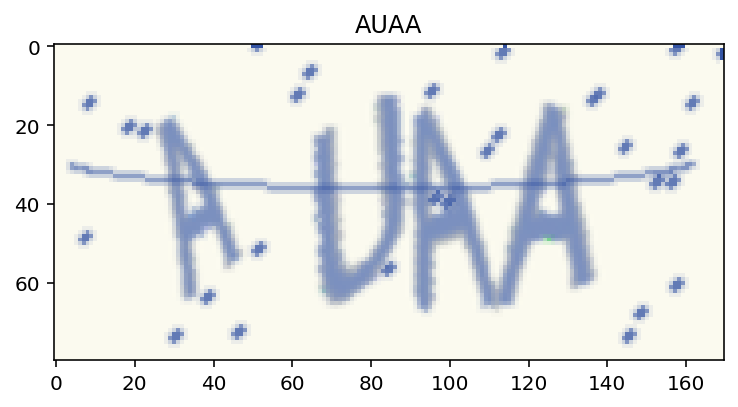

In [2]:
from captcha.image import ImageCaptcha
import numpy as np
import random
import string
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

characters = string.digits + string.ascii_uppercase
# print(characters)
width, height, n_len, n_class = 170, 80, 4, len(characters)+1    # 1 for blank class

generator = ImageCaptcha(width=width, height=height)
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

## Build Model

In [3]:
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

input_tensor = Input((height, width, 3))
x = input_tensor

for i in range(4):
  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3, 3), activation='relu')(x)
  x = BatchNormalization()(x)
  if i < 3:
    x = MaxPooling2D(pool_size=(2, 2))(x)
  else:
    x = MaxPooling2D(pool_size=(2, 1))(x)

conv_shape = x.get_shape()    # (batch_size, height, width, depth)
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)    # (batch_size, width, height*depth) for CTC Loss

x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)

pred_model = Model(inputs=input_tensor, outputs=x)    # model for prediction

In [4]:
def ctc_lambda_func(args):
  y_pred, labels, input_length, label_length = args
  return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='SGD')

### Generate Data

label:  [[14 24 22 32]]
width:  [13.]
string length:  [4.]


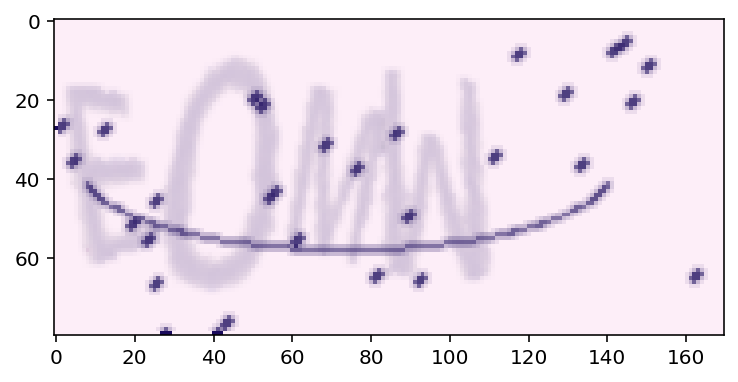

In [5]:
def gen_captcha(batch_size=128):
  x = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
  y = np.zeros((batch_size, n_len), dtype=np.uint8)
  while True:
    generator = ImageCaptcha(width=width, height=height)
    for i in range(batch_size):
      random_str = ''.join([random.choice(characters) for j in range(4)])
      x[i] = np.array(generator.generate_image(random_str))
      y[i] = [characters.find(x) for x in random_str]    # list(random_str)
    yield [x, y, np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)    # yield: return and pause here

# test if gen_captcha works
f = gen_captcha(1)
temp = next(f)
plt.imshow(temp[0][0][0])
print('label: ', temp[0][1])
print('width: ', temp[0][2])
print('string length: ', temp[0][3])

In [6]:
model.fit_generator(gen_captcha(32), steps_per_epoch=300, epochs=60)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/60
300/300 [==============================] - 105s 306ms/step - loss: 15.5984
Epoch 2/60
300/300 [==============================] - 57s 192ms/step - loss: 11.2697
Epoch 3/60
300/300 [==============================] - 57s 191ms/step - loss: 7.1801
Epoch 4/60
300/300 [==============================] - 56s 187ms/step - loss: 5.2054
Epoch 5/60
300/300 [==============================] - 56s 185ms/step - loss: 4.2685
Epoch 6/60
300/300 [==============================] - 56s 187ms/step - loss: 3.6532
Epoch 7/60
300/300 [==============================] - 56s 187ms/step - loss: 3.3679
Epoch 8/60
300/300 [==============================] - 57s 189ms/step - loss: 3.0681
Epoch 9/60
300/300 [==============================] - 56s 186ms/step - loss: 2.9062
Epoch 10/60
300/300 [==============================] - 56s 188ms/step - loss: 2.7702
Epoch 11/60
300/300 [==============================] - 56s 187ms/step - loss: 2.6097
Epoch 12/60
300/300 [==============================] - 56s 187ms/step -

## Make Predictions

Text(0.5, 1.0, 'Prediction: FK5N\nGround Truth: FK5N')

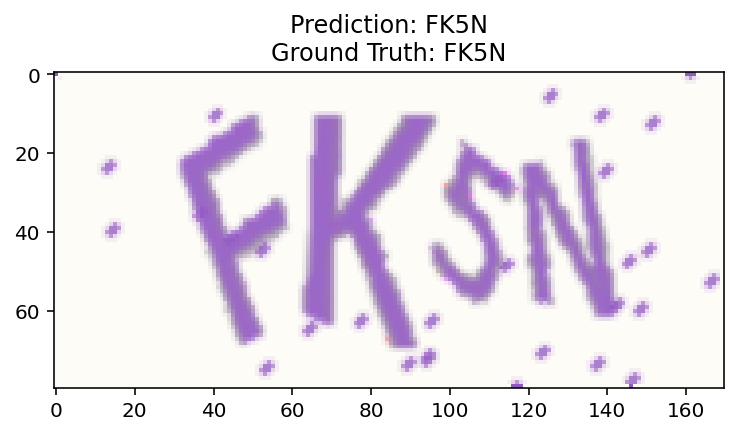

In [42]:
[x_test, y_test, _, _], _  = next(gen_captcha(1))
out = pred_model.predict(x_test)

out = K.get_value(K.ctc_decode(out, input_length=np.ones(out.shape[0])*out.shape[1])[0][0])
out = [x for x in out[0] if x!=-1]
y_test_pred = ''.join([characters[x] for x in out])
y_test = ''.join([characters[x] for x in y_test[0]])

plt.imshow(x_test[0])
plt.title("Prediction: " + str(y_test_pred) + '\nGround Truth: ' + str(y_test))